# Treino MLP no Keras (TensorFlow) e Métricas de Desempenho
## Grupo 2 - Trabalho de Conclusão de Curso
### - Bruno Uchôa Brandão e Silva - 12412440
### - Rayan Luz Ralile - 12412502

===============================================================================

### Passo 1: carregamento das bibliotecas usadas no programa

In [1]:
import numpy as np
import scipy.signal
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras.callbacks import Callback
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

2023-11-14 01:24:06.469668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Passo 2: construção das funções auxiliares

In [2]:
# Funções de salvar e carregar objetos diversos - otimizar os passos de tratamento do dataset e treino
def salva_objeto(obj, file_path = "data.pickle"):
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)
        
def carrega_objeto(file_path = "data.pickle"):
    with open(file_path, 'rb') as file:
        obj = pickle.load(file)
    return obj

### Passo 3: leitura do dataset com as labels do Keras

In [3]:
dataset = carrega_objeto("dataset.pickle")
labels = carrega_objeto("labels_keras.pickle")

### Passo 4: Codificação das labels e separação do conjunto treino e teste

In [4]:
data = dataset

# Prepara label para ser entendido na rede neural sem prejudicar os pesos
labels = labels.astype(int)
labels = np.eye(2)[labels] 

# divide os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

### Passo 5: cria, compila e treina o modelo MLP do Keras com TensorFlow usando os hiperparâmetros 'learning_rate' definido através de ensaios anteriores, arquitetura de uma camada oculta com 800 neurônios, 200 de entrada e 2 de saída, além de 50 épocas para treinamento da rede com backpropagation

In [5]:
# Cria o modelo com 800 neurônios na camada oculta, conectados a 200 neurônios na camada de entrada 
# e 2 neurônios na camada de saída
model = Sequential([
    Dense(800, activation='relu', input_shape=(200,)),
    Dense(2, activation='softmax')
])

# Configura o learning_rate (taxa de aprendizado) do otimizador ADAM
optimizer = Adam(learning_rate=0.01)

# Compila o modelo, definindo o otimizador, a função de perda e a métrica de desempenho
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Treina o modelo com os dados de treinamento, validando com os dados de teste, por 50 épocas 
# e com tamanho de lote (batch size) de 32
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)

2023-11-14 01:24:22.011289: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Passo 6: salvar a rede treinada para uso posterior na ferramenta

In [6]:
model.save('modelKeras.h5')

### Passo 7: realizar uma análise básica das métricas do modelo

In [7]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')

72/72 [==============================] - 0s 2ms/step - loss: 0.0761 - accuracy: 0.9763
Test accuracy: 0.9763157963752747


### Passo 8: plotar a curva de perdas do modelo

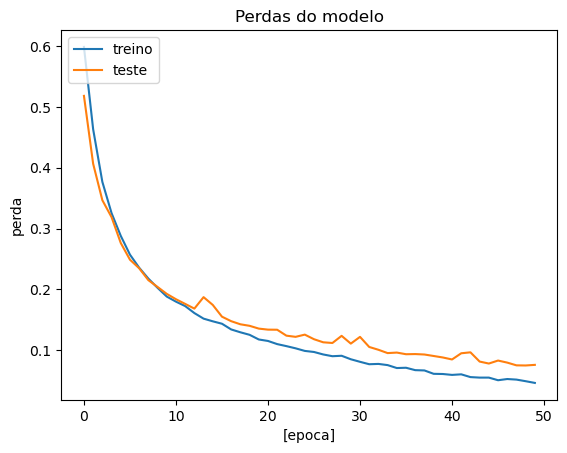

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdas do modelo')
plt.ylabel('perda')
plt.xlabel('[epoca]')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()

### Passo 9: plotar a curva de aprendizado do modelo

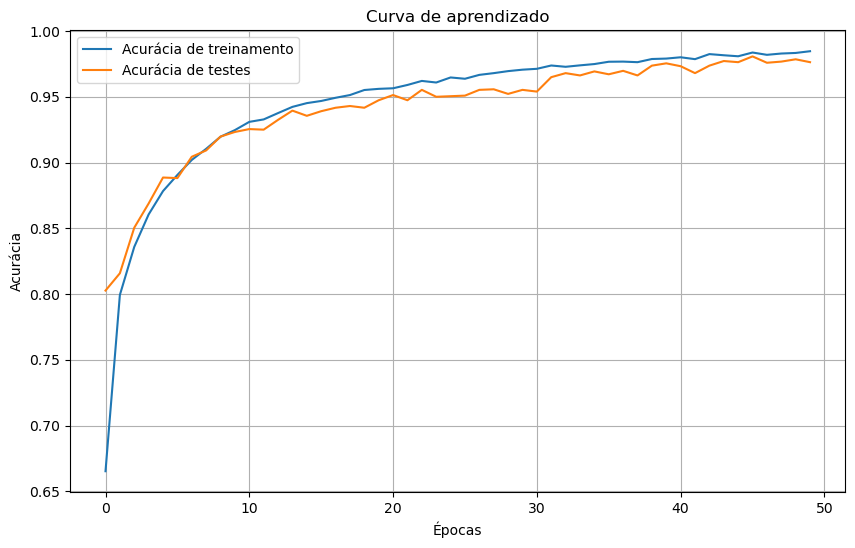

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Acurácia de treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de testes')
plt.title('Curva de aprendizado')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(loc='best')
plt.grid()
plt.show()

### Passo 10: montar matriz confusão do modelo para análise de métricas conforme demonstrado no trabalho

72/72 [==============================] - 0s 3ms/step


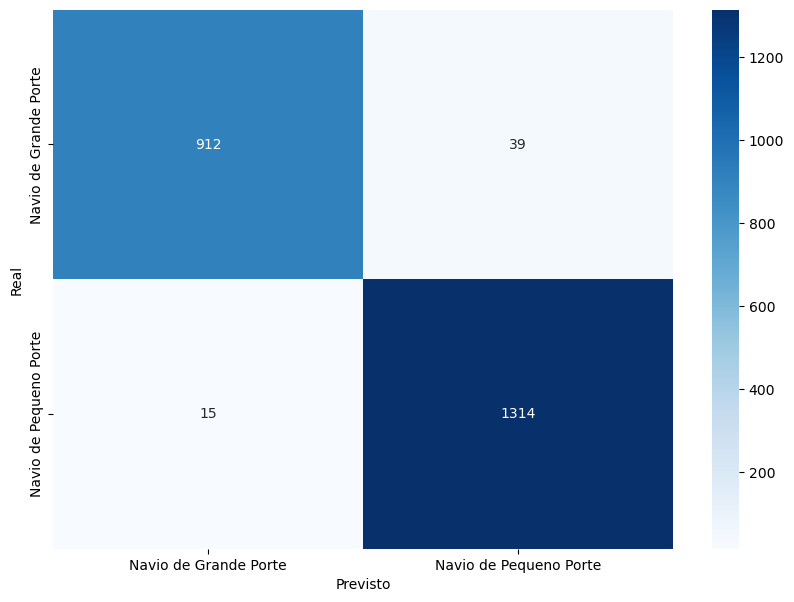

In [10]:
# Define os nomes de classes para substituir pelos números - caminho reverso
class_names = ['Navio de Grande Porte', 'Navio de Pequeno Porte']

# Uso do modelo para preditar sobre a base de testes
predictions = model.predict(X_test)

# Pega os pontos maiores de cada classificação para definir a classe
predicted_labels = np.argmax(predictions, axis=1)

# Idem para os labels verdadeiros - reais
true_labels = np.argmax(y_test, axis=1)

# Realiza a matriz de confusão
cm = confusion_matrix(true_labels, predicted_labels)

# Cria o mapa de calor da matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

### A rede já está salva e pronta para ser usada na ferramenta

## Análise de métricas da Rede Neural MLP do Keras

#### Funções auxiliares para o levantamento das métricas

In [12]:
# Métricas customizadas para entrar na chamada de treino:

def specificity(y_true, y_pred):
    true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def false_positive_rate(y_true, y_pred):
    false_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1-y_true) * y_pred, 0, 1)))
    possible_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1-y_true, 0, 1)))
    return false_positives / (possible_negatives + tf.keras.backend.epsilon())

def false_negative_rate(y_true, y_pred):
    false_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * (1-y_pred), 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    return false_negatives / (possible_positives + tf.keras.backend.epsilon())

def negative_predictive_value(y_true, y_pred):
    true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1-y_true) * (1-y_pred), 0, 1)))
    predicted_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1-y_pred, 0, 1)))
    return true_negatives / (predicted_negatives + tf.keras.backend.epsilon())


#### Novo treino da rede com fins de levantamento das métricas

In [13]:
dataset = carrega_objeto("dataset.pickle")
labels = carrega_objeto("labels_keras.pickle")

data = dataset

# Prepara label para ser entendido na rede neural sem prejudicar os pesos
labels = labels.astype(int)
labels = np.eye(2)[labels] 

# divide os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# cria o modelo com 800 neurônios na camada oculta, conectados a 200 na entrada e 2 na saída
model = Sequential([
    Dense(800, activation='relu', input_shape=(200,)),
    Dense(2, activation='softmax')
])

# Configura o learning_rate do otimizador ADAM
optimizer = Adam(learning_rate=0.01)



# compila e treina o modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        specificity,
        false_positive_rate,
        false_negative_rate,
        negative_predictive_value,
        tf.keras.metrics.AUC(name='auc')
    ]
)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
285/285 [==============================] - 3s 7ms/step - loss: 0.5992 - accuracy: 0.6634 - precision: 0.6634 - recall: 0.6634 - specificity: 0.6634 - false_positive_rate: 0.3366 - false_negative_rate: 0.3366 - negative_predictive_value: 0.6634 - auc: 0.7458 - val_loss: 0.5127 - val_accuracy: 0.7526 - val_precision: 0.7526 - val_recall: 0.7526 - val_specificity: 0.7539 - val_false_positive_rate: 0.2461 - val_false_negative_rate: 0.2461 - val_negative_predictive_value: 0.7539 - val_auc: 0.8574
Epoch 2/50
285/285 [==============================] - 3s 10ms/step - loss: 0.4669 - accuracy: 0.7934 - precision: 0.7934 - recall: 0.7934 - specificity: 0.7934 - false_positive_rate: 0.2066 - false_negative_rate: 0.2066 - negative_predictive_value: 0.7934 - auc: 0.8805 - val_loss: 0.4138 - val_accuracy: 0.8355 - val_precision: 0.8355 - val_recall: 0.8355 - val_specificity: 0.8359 - val_false_positive_rate: 0.1641 - val_false_negative_rate: 0.1641 - val_negative_predictive_value: 0.8359 -

285/285 [==============================] - 1s 4ms/step - loss: 0.0789 - accuracy: 0.9724 - precision: 0.9724 - recall: 0.9724 - specificity: 0.9724 - false_positive_rate: 0.0276 - false_negative_rate: 0.0276 - negative_predictive_value: 0.9724 - auc: 0.9963 - val_loss: 0.0990 - val_accuracy: 0.9649 - val_precision: 0.9649 - val_recall: 0.9649 - val_specificity: 0.9653 - val_false_positive_rate: 0.0347 - val_false_negative_rate: 0.0347 - val_negative_predictive_value: 0.9653 - val_auc: 0.9950
Epoch 34/50
285/285 [==============================] - 1s 5ms/step - loss: 0.0770 - accuracy: 0.9742 - precision: 0.9742 - recall: 0.9742 - specificity: 0.9742 - false_positive_rate: 0.0258 - false_negative_rate: 0.0258 - negative_predictive_value: 0.9742 - auc: 0.9964 - val_loss: 0.1051 - val_accuracy: 0.9627 - val_precision: 0.9627 - val_recall: 0.9627 - val_specificity: 0.9631 - val_false_positive_rate: 0.0369 - val_false_negative_rate: 0.0369 - val_negative_predictive_value: 0.9631 - val_auc: 0